In [1]:
import numpy as np
import torch

from tqdm.auto import tqdm
from pathlib import Path

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# plotting functions

import io
import cv2

from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def get_img_from_fig(fig, dpi=350):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    im = Image.fromarray(img)
    im = trim(im)
    
    im = np.asarray(im)
    return im

def my_rescale_denogram(counts, deno_img, interpolation=cv2.INTER_NEAREST):
    #counts.shape: (n_rois, k)
    deno_img = cv2.resize(deno_img, dsize=(8000, 1000), interpolation=interpolation)
#     print(deno_img.shape)
    new_img = np.zeros(shape=deno_img.shape)    
    k_counts = counts.sum(0)
    k_percent = k_counts / k_counts.sum()    
    # print(k_percent)
    lens = k_percent * deno_img.shape[1]
    k_split_ends = np.cumsum(lens).astype(np.int32)
    n_rois, n_k = counts.shape
#     print(k_split_ends)
    for i_k in range(n_k):
        if i_k != 0:
            i_k_start = k_split_ends[i_k-1]
        else:
            i_k_start = 0
        i_k_end = k_split_ends[i_k]
        if i_k_end == i_k_start:
            i_k_end += 1
#         print(i_k_start, i_k_end)
        width = i_k_end - i_k_start

        old_clip = deno_img[:, 
                            int(i_k * (deno_img.shape[1]/n_k)):int((i_k+1) * (deno_img.shape[1]/n_k)), 
                            :]
        # print(width)
        res = cv2.resize(old_clip, dsize=(width, deno_img.shape[0]), interpolation=interpolation)
#         res = scale(old_clip, old_clip.shape[0], width)
#         print(old_clip.shape, res.shape)
        new_img[:, i_k_start:i_k_end, :] = res
    return new_img

def my_heatmap(counts):
    #counts.shape: (n_rois, k)
    img = np.zeros(shape=(1000, 8000))
    percentages = counts / counts.sum(1, keepdims=True)
    
    k_counts = counts.sum(0)
    k_percent = k_counts / k_counts.sum()
    lens = k_percent * img.shape[1]
    k_split_ends = np.cumsum(lens).astype(np.int32)
    
    n_rois, n_k = counts.shape
    
    for i_k in range(n_k):
        if i_k != 0:
            i_k_start = k_split_ends[i_k-1]
        else:
            i_k_start = 0
        i_k_end = k_split_ends[i_k]
        for i_roi in range(n_rois):
            i_roi_start = int(i_roi * (img.shape[0]/n_rois))
            i_roi_end = int((i_roi+1) * (img.shape[0]/n_rois))
            
            img[i_roi_start:i_roi_end, i_k_start:i_k_end] = percentages[i_roi, i_k]
    
    return img

def my_heatmap2(scores, counts):
    #counts.shape: (n_rois, k)
    img = np.zeros(shape=(100, 8000))
    
    k_counts = counts.sum(0)
    k_percent = k_counts / k_counts.sum()
    lens = k_percent * img.shape[1]
    k_split_ends = np.cumsum(lens).astype(np.int32)
#     print(k_split_ends)
    
    n_k = counts.shape[1]
    
    for i_k in range(n_k):
        if i_k != 0:
            i_k_start = k_split_ends[i_k-1]
        else:
            i_k_start = 0
        i_k_end = k_split_ends[i_k]
            
        img[:, i_k_start:i_k_end] = scores[i_k]
    
    return img

In [77]:
import json

config_file = 'config/anatomical rois.json'
with open(config_file, 'r') as f:
    anatomical_rois = json.load(f)

In [78]:
TEMP_DIR = Path('/data/huze/ray_results/algonauts2021/tmp/notebook-010/')

backbone_names = np.load(TEMP_DIR.joinpath(Path(f'all-loaded_backbone_names.npy'))).tolist()

In [79]:
voxel_indices_save_dir = Path('./tmp/notebook012/')
voxel_indices_save_dir.mkdir(parents=True, exist_ok=True)

In [80]:
backbone_names = ['all'] + backbone_names

In [81]:
backbone_names

['all',
 '2d_densnet_warp_3d',
 '3d_swin',
 '2d_bdcnvgg_warp_3d',
 'i3d_flow',
 '2d_moby_swin_warp_3d',
 'i3d_rgb',
 '2d_seg_swin_warp_3d',
 'audio_vggish',
 '2d_pyconvsegnet_warp_3d',
 '2d_simclr_warp_3d',
 '2d_colorizer_warp_3d']

In [ ]:
size_split_dict = {}

In [94]:
size_split_dict = {
    'L': [23, 98, 64, 66, 7],
    'M': [23, 98, 29, 53, 64, 66, 7],
    'S': [23, 98, 65, 29, 53, 64, 66, 7],
    'SS': [23, 98, 65, 29, 53, 18, 64, 66, 7],
    'XS': [23, 98, 65, 81, 29, 56, 53, 18, 64, 66, 7],
}

In [95]:
optimal_ordering = True

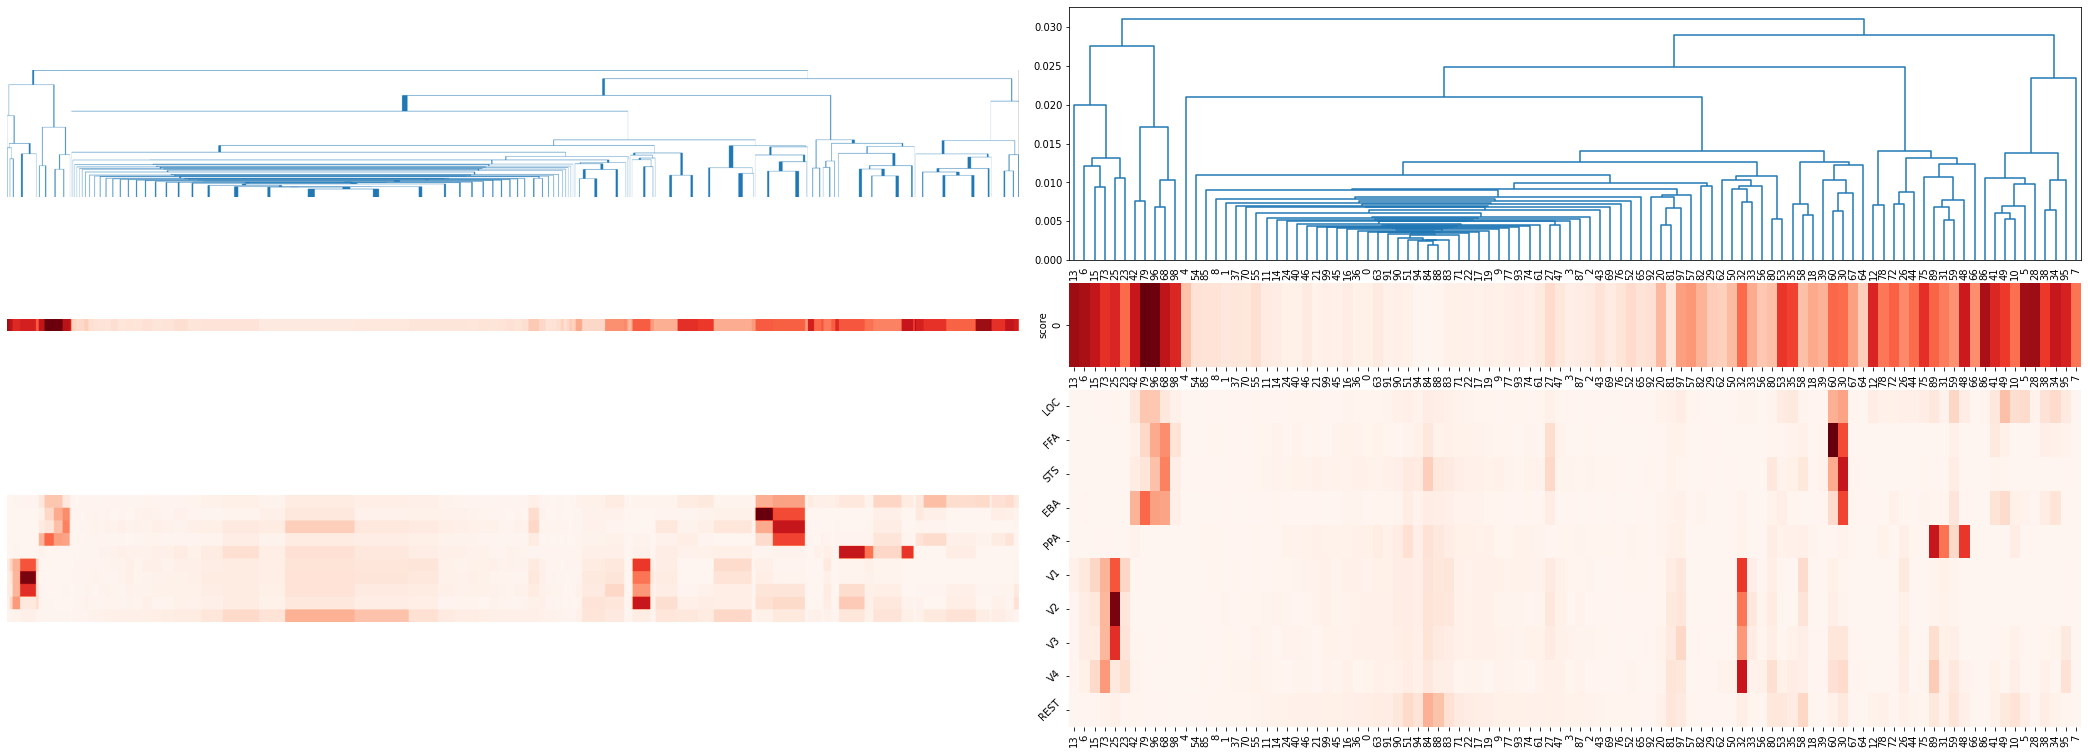

working on: L
nList is -  [23, 98, 64, 66, 7]
cluster 1 [13, 6, 15, 73, 25, 23]
cluster 2 [42, 79, 96, 68, 98]
cluster 3 [4, 54, 85, 8, 1, 37, 70, 55, 11, 14, 24, 40, 46, 21, 99, 45, 16, 36, 0, 63, 91, 90, 51, 94, 84, 88, 83, 71, 22, 17, 19, 9, 77, 93, 74, 61, 27, 47, 3, 87, 2, 43, 69, 76, 52, 65, 92, 20, 81, 97, 57, 82, 29, 62, 50, 32, 33, 56, 80, 53, 35, 58, 18, 39, 60, 30, 67, 64]
cluster 4 [12, 78, 72, 26, 44, 75, 89, 31, 59, 48, 66]
cluster 5 [86, 41, 49, 10, 5, 28, 38, 34, 95, 7]
working on: M
nList is -  [23, 98, 29, 53, 64, 66, 7]
cluster 1 [13, 6, 15, 73, 25, 23]
cluster 2 [42, 79, 96, 68, 98]
cluster 3 [4, 54, 85, 8, 1, 37, 70, 55, 11, 14, 24, 40, 46, 21, 99, 45, 16, 36, 0, 63, 91, 90, 51, 94, 84, 88, 83, 71, 22, 17, 19, 9, 77, 93, 74, 61, 27, 47, 3, 87, 2, 43, 69, 76, 52, 65, 92, 20, 81, 97, 57, 82, 29]
cluster 4 [62, 50, 32, 33, 56, 80, 53]
cluster 5 [35, 58, 18, 39, 60, 30, 67, 64]
cluster 6 [12, 78, 72, 26, 44, 75, 89, 31, 59, 48, 66]
cluster 7 [86, 41, 49, 10, 5, 28, 38,

In [96]:
# work on 'all', different size
backbone_name = 'all'

plt.clf()
plt.cla()
plt.close()

km = torch.load(f'tmp/notebook011/{backbone_name}-kmeans.pt')
voxel_scores = np.load(TEMP_DIR.joinpath(Path(f'{backbone_name}-voxel_scores.npy')))



Z = linkage(km.cluster_centers_, 'ward', optimal_ordering=optimal_ordering)

fig = plt.figure(figsize=(30, 10))
dn = dendrogram(Z, get_leaves=True, color_threshold=0)
plt.axis('off')
# plt.show()
deno_img = get_img_from_fig(fig, dpi=350)
plt.close()

counts = [sum(km.labels_ == i) for i in dn['leaves']]
counts = np.asarray(counts).reshape(1, -1)

k = km.n_clusters

new_img = my_rescale_denogram(counts, deno_img)

im = Image.fromarray(new_img.astype(np.uint8))

km_cluster_mean_scores = np.zeros(k)
for i in range(k):
    km_cluster_mean_scores[i] = voxel_scores[km.labels_ == i].mean()

dn_cluster_mean_scores = km_cluster_mean_scores[dn['leaves']]

score_im = my_heatmap2(dn_cluster_mean_scores, counts)


### plot

fig = plt.figure(constrained_layout=False, figsize=(30, 10))
widths = [40, 40]
heights = [3, 1, 4]
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                          height_ratios=heights, left=0.02, right=0.98, wspace=0.05)

## plot scaled

# plot denogram
plt.sca(fig.add_subplot(spec[0, 0]))
plt.imshow(im)
plt.axis('off')

# plot score
plt.sca(fig.add_subplot(spec[1, 0]))
plt.imshow(score_im, cmap='Reds')
plt.axis('off')

# plot anatomical rois for refrence
plt.sca(fig.add_subplot(spec[2, 0]))
new_labels = np.ones_like(km.labels_) * -1
new_order = np.asarray(dn['leaves'])
for i in range(km.n_clusters):
    new_labels[km.labels_ == new_order[i]] = i
ls = new_labels

def my_count(arr, m):
    counts = []
    for i in range(m):
        counts.append((arr==i).sum())
    counts = np.asarray(counts)
    return counts
sidx = np.argsort(my_count(ls, k)).tolist()[::-1]

rois = list(anatomical_rois.keys())
counts = []
for roi in rois:
    count = my_count(ls[anatomical_rois[roi]], k)
    counts.append(count)
counts = np.stack(counts)
percentages = counts / counts.sum(1, keepdims=True)

img = my_heatmap(counts)

plt.imshow(img, cmap='Reds')
plt.axis('off')


## plot unscaled

# plot denogram
plt.sca(fig.add_subplot(spec[0, 1]))
dn = dendrogram(Z, get_leaves=True, color_threshold=0, show_leaf_counts=True)
plt.xticks(fontsize=10, rotation=90)

# plot score
plt.sca(fig.add_subplot(spec[1, 1]))
sns.heatmap(dn_cluster_mean_scores.reshape(1, -1), xticklabels=dn['leaves'], cmap='Reds', cbar=False)
plt.ylabel('score')


# plot anatomical rois for refrence
plt.sca(fig.add_subplot(spec[2, 1]))
ax = sns.heatmap(percentages, yticklabels=rois, xticklabels=dn['leaves'], annot=False, cmap='Reds', cbar=False)
plt.yticks(rotation=45)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0.1, wspace = 0.02)


plt.show()    
    
for size in ['L', 'M', 'S', 'XS']:
    print("working on:", size)
    if not size in size_split_dict.keys():
        # number of elements
        # n = int(input("Enter number of clusters : "))
        # Below line read inputs from user using map() function
        # split_list = list(map(int,input("nEnter the numbers : ").strip().split()))[:n]
        split_list = list(map(int,input("nEnter the split breakpoints: ").strip().split()))
        size_split_dict[size] = split_list
    else:
        split_list = size_split_dict[size]
    print("nList is - ", split_list)
    
    
    # extract and save voxel_indices
    start = 0
    for i, end in enumerate(split_list):
        i += 1

        labels = dn['leaves'][start:dn['leaves'].index(end)+1]
        print(f'cluster {i}', labels)
        start += len(labels)

        voxel_idxs = []
        for l in labels:
            voxel_idx = (km.labels_ == l).nonzero()[0]
            voxel_idxs.append(voxel_idx)
        voxel_idxs = np.concatenate(voxel_idxs)
        voxel_idxs.sort()
        voxel_idxs = torch.tensor(voxel_idxs)
        torch.save(voxel_idxs, voxel_indices_save_dir.joinpath(Path(f'{size}-htROI{i}.pt')))
        
    title = ','.join([str(i) for i in split_list])
    
    fig.suptitle(title, fontsize=16)
    fig.savefig(f'tmp/notebook012/figs/all_backbone_{size}.pdf')
    
    # plt.close()
    # clear_output(wait=True)

In [82]:
# save progress
split_dict = {}

In [83]:
split_dict = {
    'all': [23, 98, 65, 29, 53, 64, 66, 7],
    'i3d_rgb': [15, 26, 39, 36, 77, 35],
 '2d_densnet_warp_3d': [5, 87, 84, 73, 70, 99, 81],
 '3d_swin': [22, 53, 9, 28, 50, 91],
 '2d_bdcnvgg_warp_3d': [5, 66, 50, 28, 37, 23],
 'i3d_flow': [51, 52, 86, 39, 25, 83, 41],
 '2d_moby_swin_warp_3d': [80, 94, 89, 21, 53, 79],
 '2d_seg_swin_warp_3d': [76, 1, 33, 96, 70, 54],
 'audio_vggish': [51, 46, 60, 21, 85],
 '2d_pyconvsegnet_warp_3d': [14, 68, 26, 49, 65],
 '2d_simclr_warp_3d': [26, 47, 93, 65, 55, 95, 48, 9, 74],
 '2d_colorizer_warp_3d': [58, 12, 20, 23, 33, 74]}

In [84]:
optimal_ordering = True

In [85]:
rois = list(anatomical_rois.keys())
label_rois = list(r.replace('REST', 'others') for r in anatomical_rois.keys())

In [86]:
label_rois

['LOC', 'FFA', 'STS', 'EBA', 'PPA', 'V1', 'V2', 'V3', 'V4', 'others']

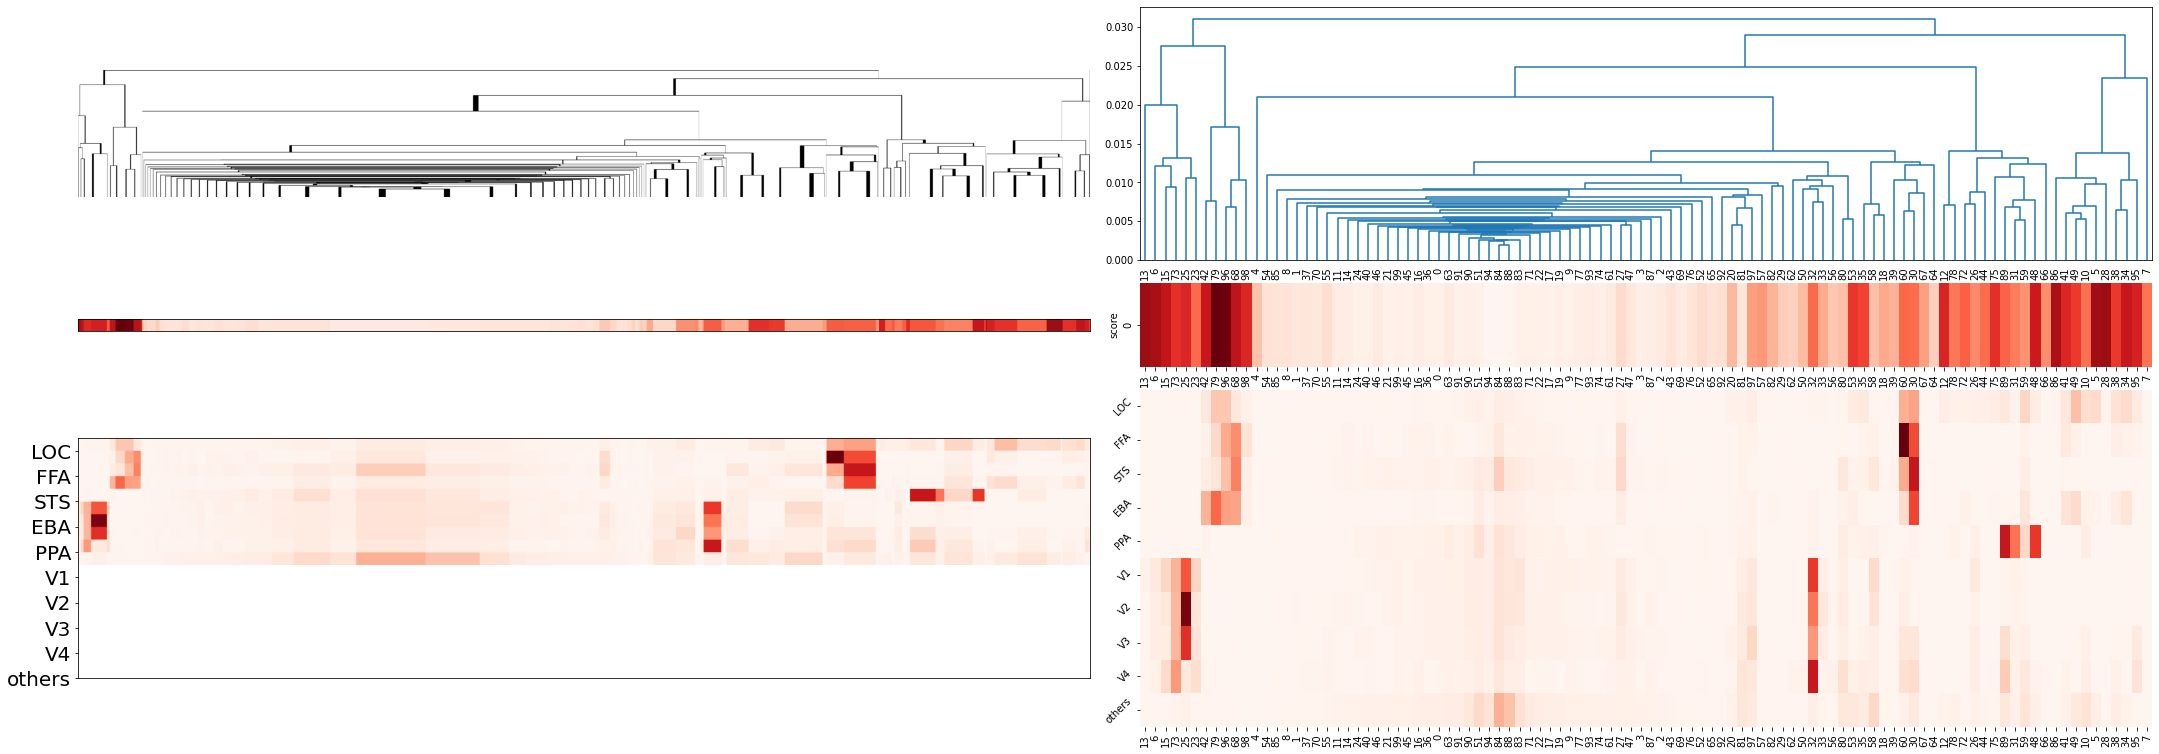

working on: all
nList is -  [23, 98, 65, 29, 53, 64, 66, 7]
cluster 1 [13, 6, 15, 73, 25, 23]
cluster 2 [42, 79, 96, 68, 98]
cluster 3 [4, 54, 85, 8, 1, 37, 70, 55, 11, 14, 24, 40, 46, 21, 99, 45, 16, 36, 0, 63, 91, 90, 51, 94, 84, 88, 83, 71, 22, 17, 19, 9, 77, 93, 74, 61, 27, 47, 3, 87, 2, 43, 69, 76, 52, 65]
cluster 4 [92, 20, 81, 97, 57, 82, 29]
cluster 5 [62, 50, 32, 33, 56, 80, 53]
cluster 6 [35, 58, 18, 39, 60, 30, 67, 64]
cluster 7 [12, 78, 72, 26, 44, 75, 89, 31, 59, 48, 66]
cluster 8 [86, 41, 49, 10, 5, 28, 38, 34, 95, 7]


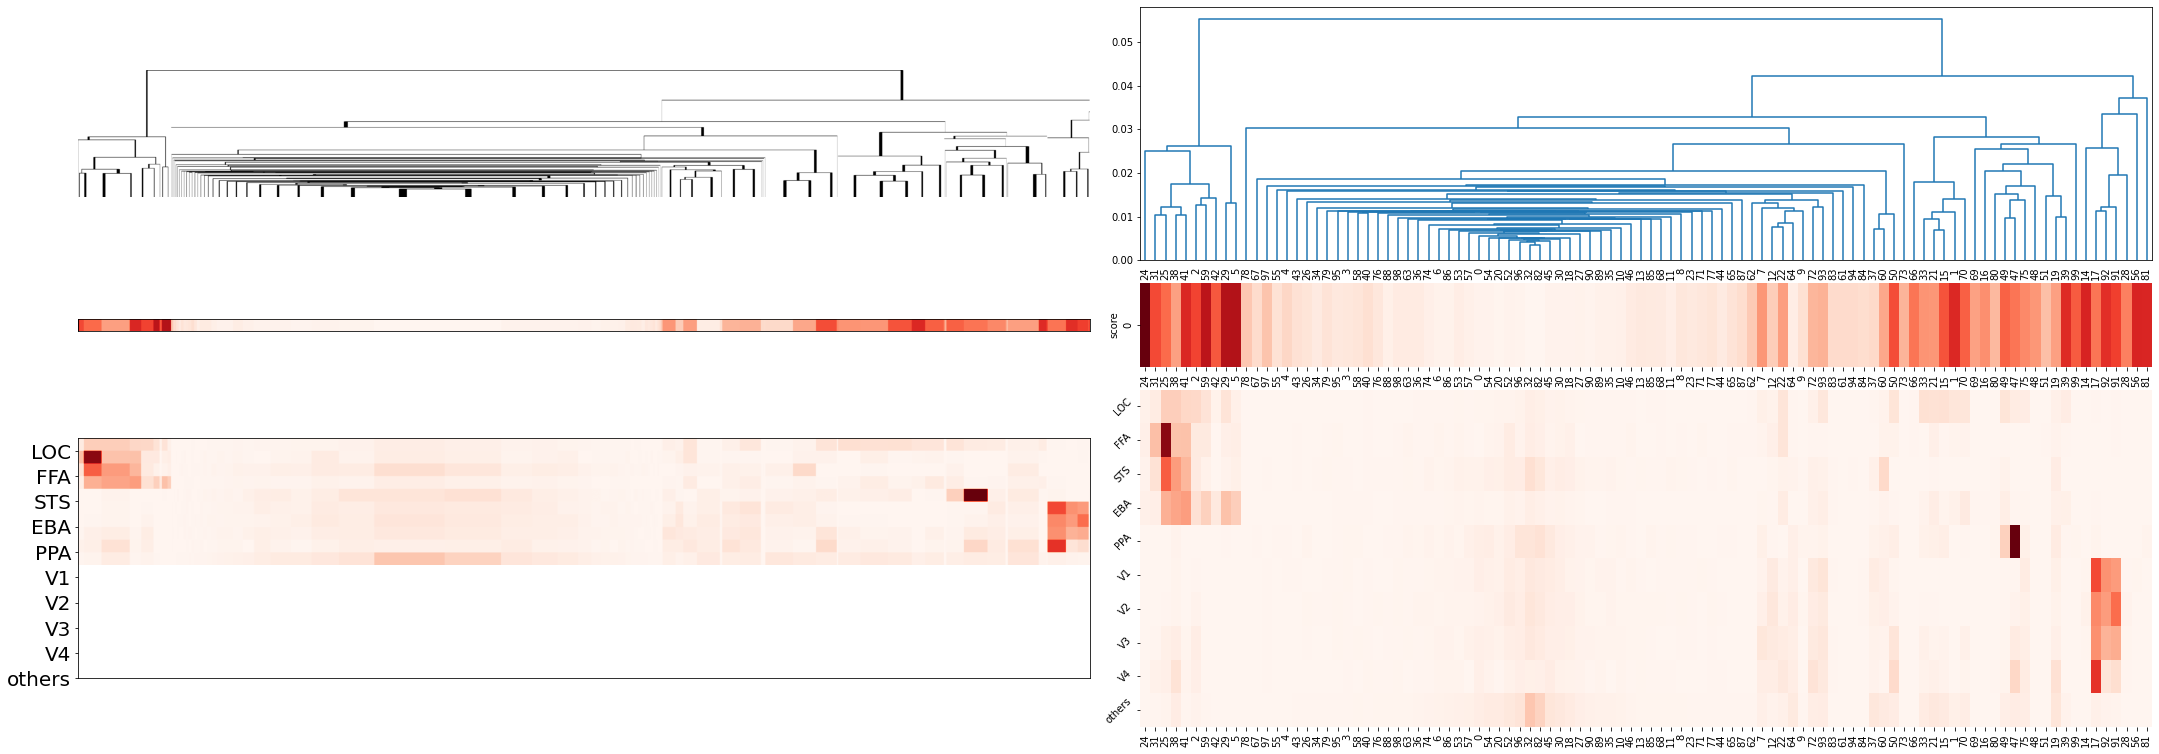

working on: 2d_densnet_warp_3d
nList is -  [5, 87, 84, 73, 70, 99, 81]
cluster 1 [24, 31, 25, 38, 41, 2, 59, 42, 29, 5]
cluster 2 [78, 67, 97, 55, 4, 43, 26, 34, 79, 95, 3, 58, 40, 76, 88, 98, 63, 36, 74, 6, 86, 53, 57, 0, 54, 20, 52, 96, 32, 82, 45, 30, 18, 27, 90, 89, 35, 10, 46, 13, 85, 68, 11, 8, 23, 71, 77, 44, 65, 87]
cluster 3 [62, 7, 12, 22, 64, 9, 72, 93, 83, 61, 94, 84]
cluster 4 [37, 60, 50, 73]
cluster 5 [66, 33, 21, 15, 1, 70]
cluster 6 [69, 16, 80, 49, 47, 75, 48, 51, 19, 39, 99]
cluster 7 [14, 17, 92, 91, 28, 56, 81]


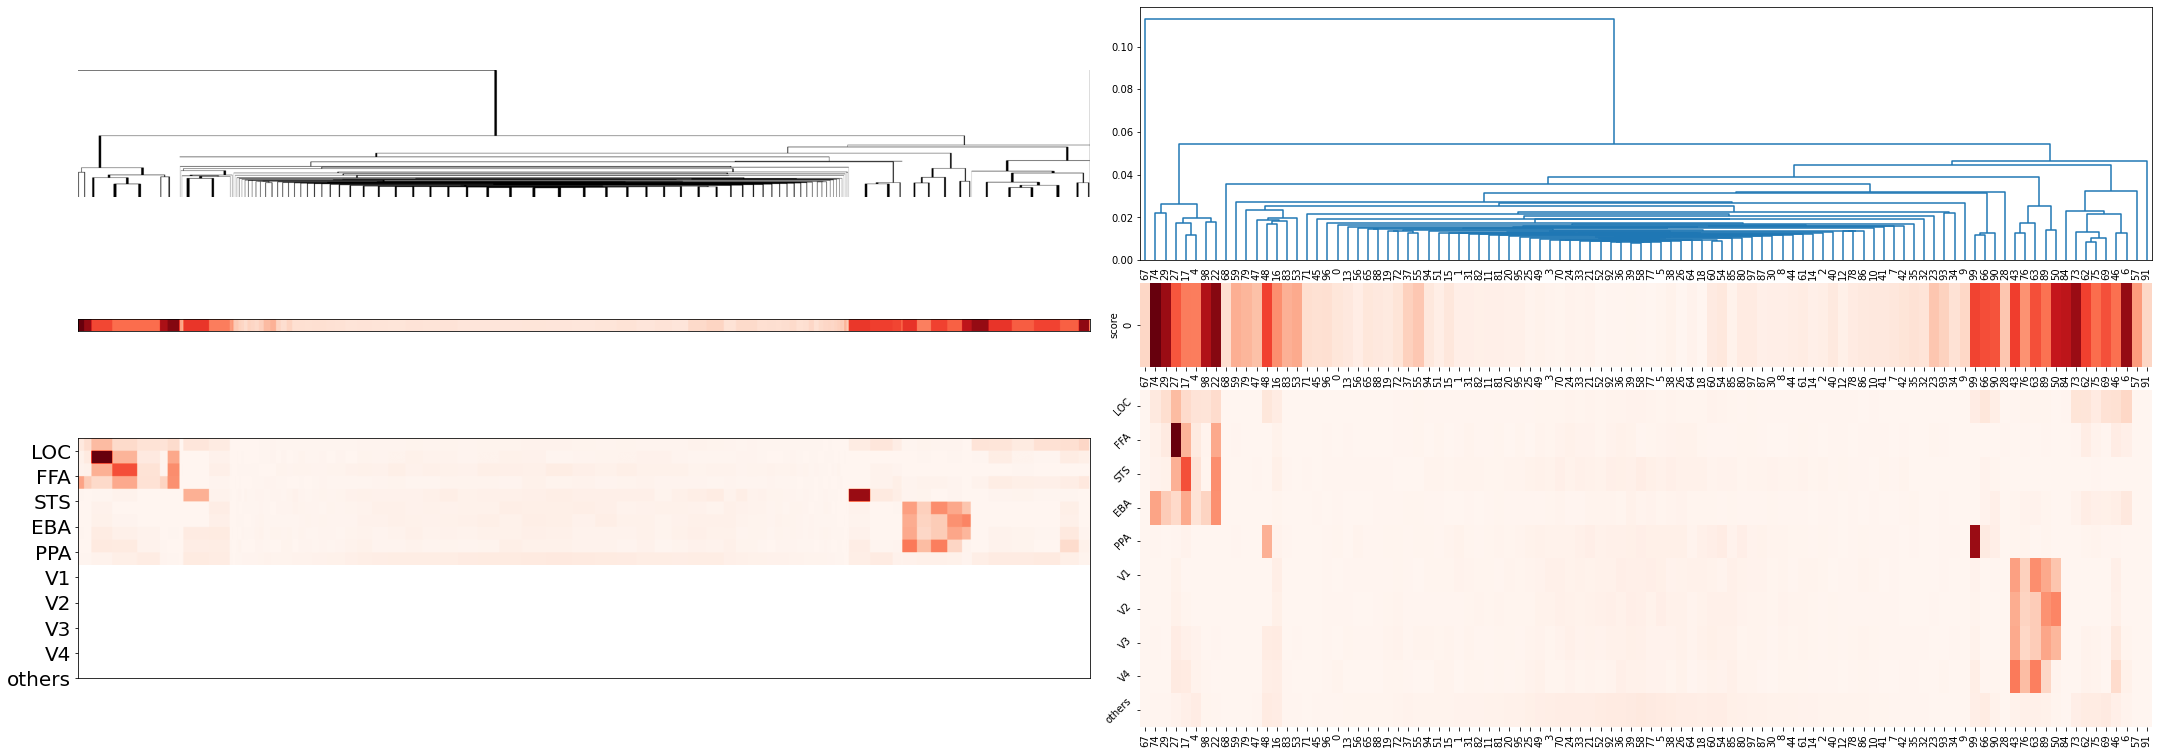

working on: 3d_swin
nList is -  [22, 53, 9, 28, 50, 91]
cluster 1 [67, 74, 29, 27, 17, 4, 98, 22]
cluster 2 [68, 59, 79, 47, 48, 16, 83, 53]
cluster 3 [71, 45, 96, 0, 13, 56, 65, 88, 19, 72, 37, 55, 94, 51, 15, 1, 31, 82, 11, 81, 20, 95, 25, 49, 3, 70, 24, 33, 21, 52, 92, 36, 39, 58, 77, 5, 38, 26, 64, 18, 60, 54, 85, 80, 97, 87, 30, 8, 44, 61, 14, 2, 40, 12, 78, 86, 10, 41, 7, 42, 35, 32, 23, 93, 34, 9]
cluster 4 [99, 66, 90, 28]
cluster 5 [43, 76, 63, 89, 50]
cluster 6 [84, 73, 62, 75, 69, 46, 6, 57, 91]


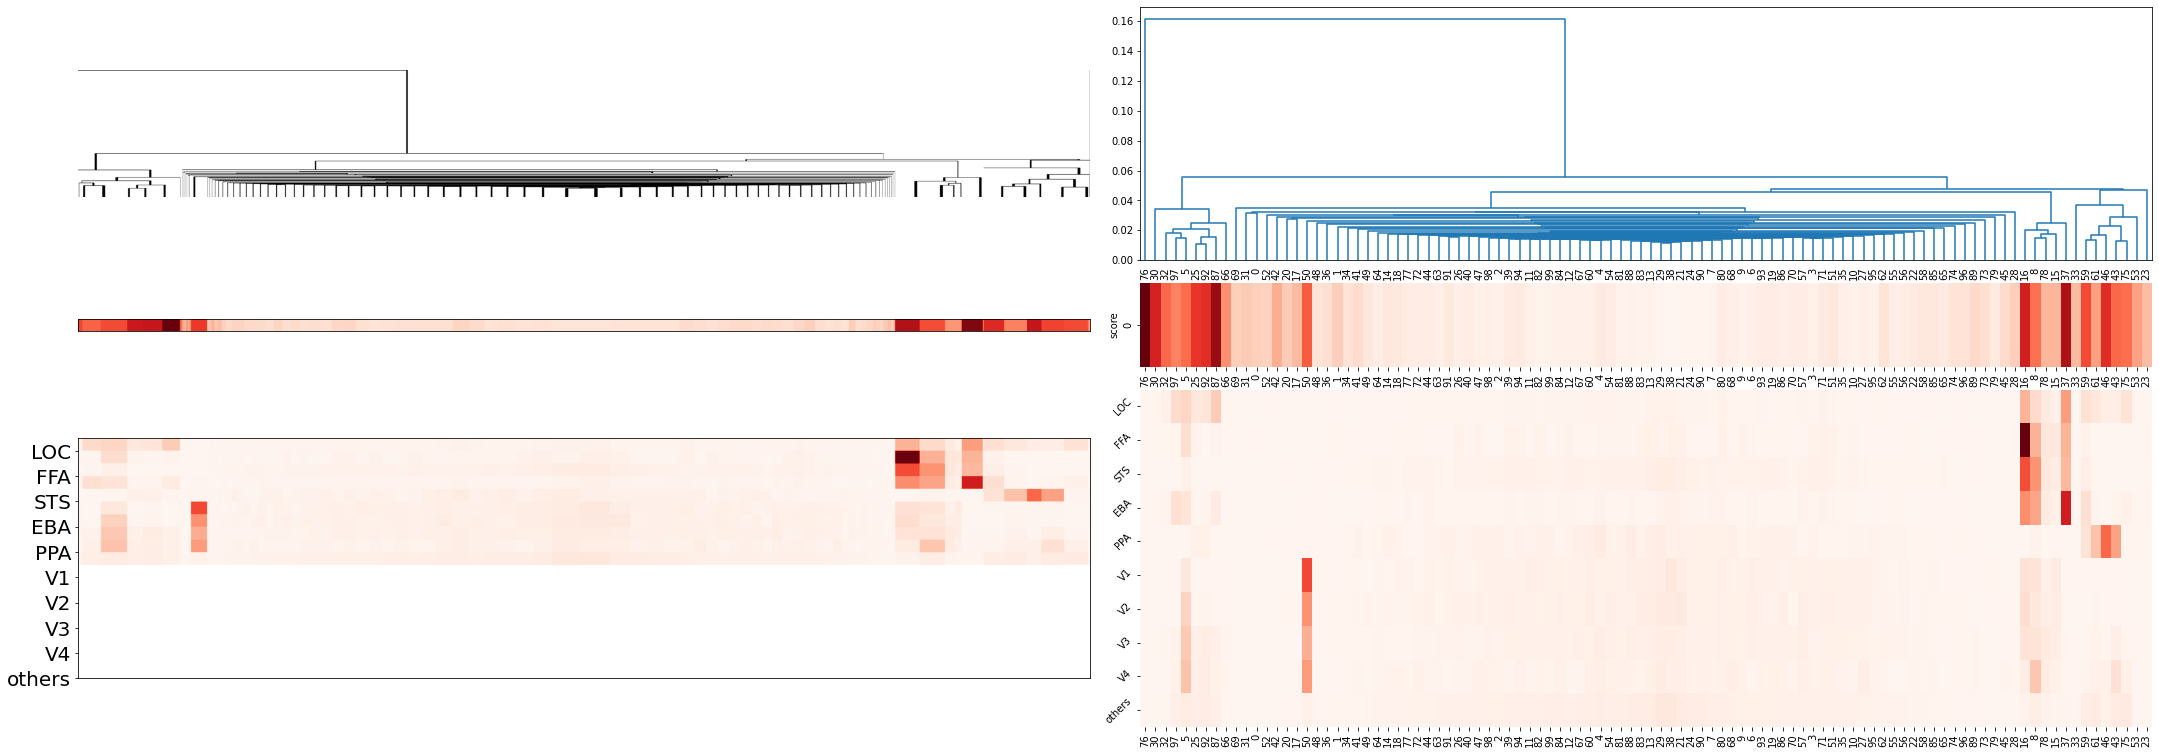

working on: 2d_bdcnvgg_warp_3d
nList is -  [5, 66, 50, 28, 37, 23]
cluster 1 [76, 30, 32, 97, 5]
cluster 2 [25, 92, 87, 66]
cluster 3 [69, 31, 0, 52, 42, 20, 17, 50]
cluster 4 [48, 36, 1, 34, 41, 49, 64, 14, 18, 77, 72, 44, 63, 91, 26, 40, 47, 98, 2, 39, 94, 11, 82, 99, 84, 12, 67, 60, 4, 54, 81, 88, 83, 13, 29, 38, 21, 24, 90, 7, 80, 68, 9, 6, 93, 19, 86, 70, 57, 3, 71, 51, 35, 10, 27, 95, 62, 55, 56, 22, 58, 85, 65, 74, 96, 89, 73, 79, 45, 28]
cluster 5 [16, 8, 78, 15, 37]
cluster 6 [33, 59, 61, 46, 43, 75, 53, 23]


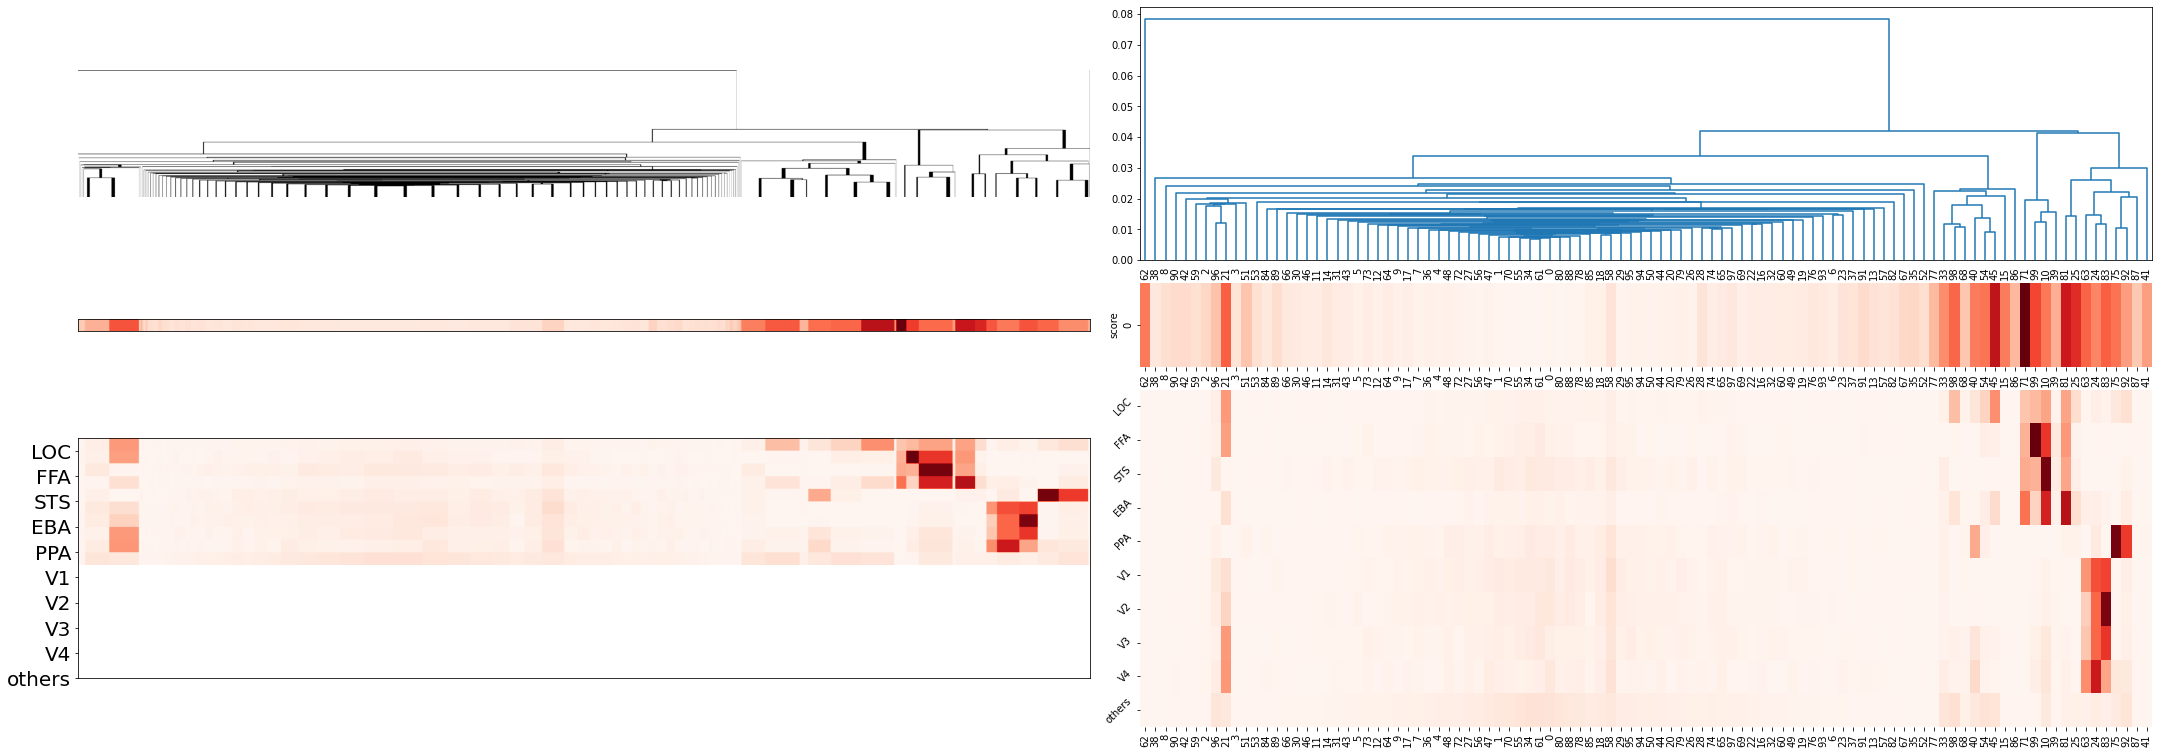

working on: i3d_flow
nList is -  [51, 52, 86, 39, 25, 83, 41]
cluster 1 [62, 38, 8, 90, 42, 59, 2, 96, 21, 3, 51]
cluster 2 [53, 84, 89, 66, 30, 46, 11, 14, 31, 43, 5, 73, 12, 64, 9, 17, 7, 36, 4, 48, 72, 27, 56, 47, 1, 70, 55, 34, 61, 0, 80, 88, 78, 85, 18, 58, 29, 95, 94, 50, 44, 20, 79, 26, 28, 74, 65, 97, 69, 22, 16, 32, 60, 49, 19, 76, 93, 6, 23, 37, 91, 13, 57, 82, 67, 35, 52]
cluster 3 [77, 33, 98, 68, 40, 54, 45, 15, 86]
cluster 4 [71, 99, 10, 39]
cluster 5 [81, 25]
cluster 6 [63, 24, 83]
cluster 7 [75, 92, 87, 41]


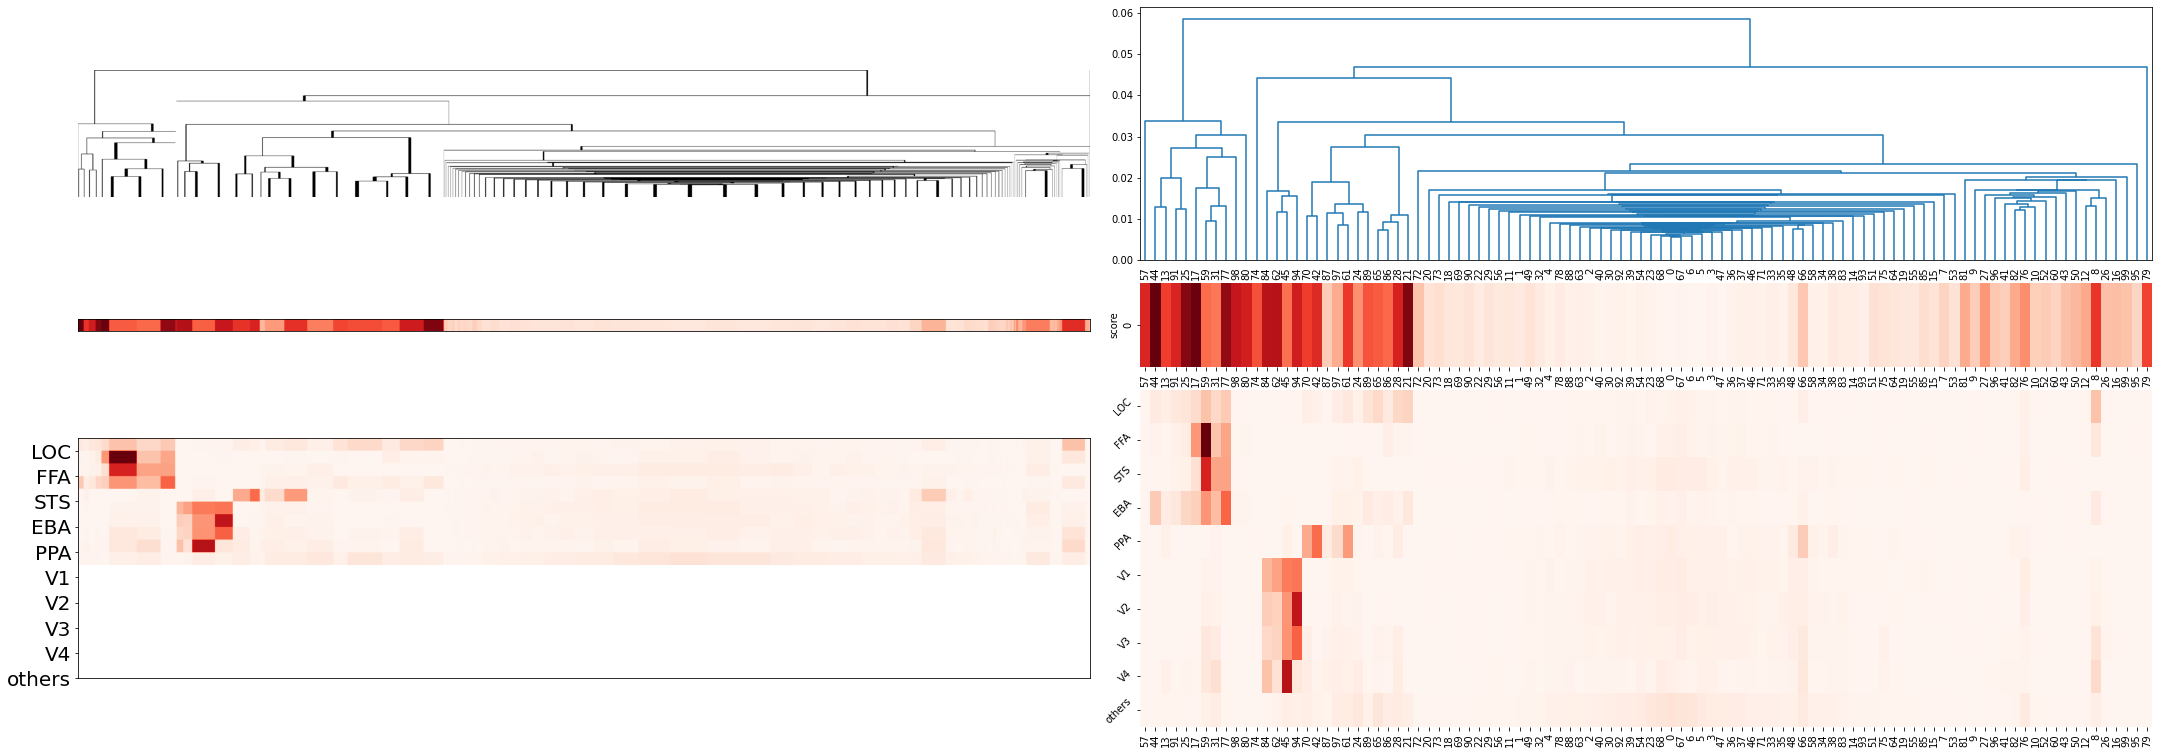

working on: 2d_moby_swin_warp_3d
nList is -  [80, 94, 89, 21, 53, 79]
cluster 1 [57, 44, 13, 91, 25, 17, 59, 31, 77, 98, 80]
cluster 2 [74, 84, 62, 45, 94]
cluster 3 [70, 42, 87, 97, 61, 24, 89]
cluster 4 [65, 86, 28, 21]
cluster 5 [72, 20, 73, 18, 69, 90, 22, 29, 56, 11, 1, 49, 32, 4, 78, 88, 63, 2, 40, 30, 92, 39, 54, 23, 68, 0, 67, 6, 5, 3, 47, 36, 37, 46, 71, 33, 35, 48, 66, 58, 34, 38, 83, 14, 93, 51, 75, 64, 19, 55, 85, 15, 7, 53]
cluster 6 [81, 9, 27, 96, 41, 82, 76, 10, 52, 60, 43, 50, 12, 8, 26, 16, 99, 95, 79]


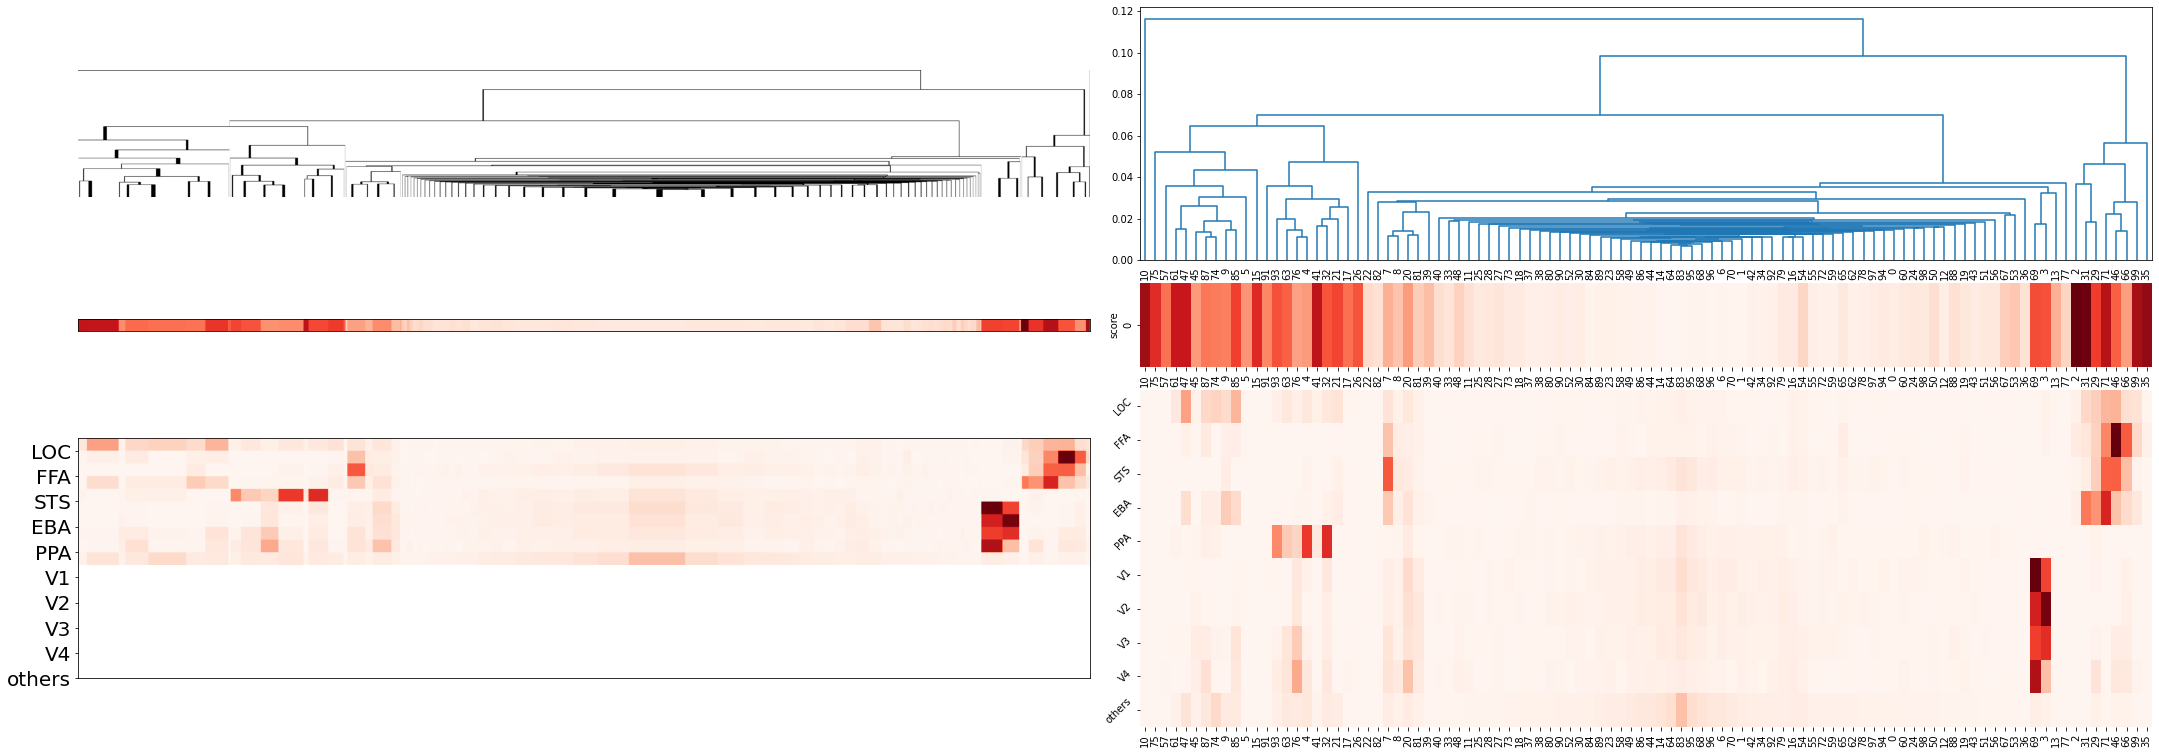

working on: i3d_rgb
nList is -  [15, 26, 39, 36, 77, 35]
cluster 1 [10, 75, 57, 61, 47, 45, 87, 74, 9, 85, 5, 15]
cluster 2 [91, 93, 63, 76, 4, 41, 32, 21, 17, 26]
cluster 3 [22, 82, 7, 8, 20, 81, 39]
cluster 4 [40, 33, 48, 11, 25, 28, 27, 73, 18, 37, 38, 80, 90, 52, 30, 84, 89, 23, 58, 49, 86, 44, 14, 64, 83, 95, 68, 96, 6, 70, 1, 42, 34, 92, 79, 16, 54, 55, 72, 59, 65, 62, 78, 97, 94, 0, 60, 24, 98, 50, 12, 88, 19, 43, 51, 56, 67, 53, 36]
cluster 5 [69, 3, 13, 77]
cluster 6 [2, 31, 29, 71, 46, 66, 99, 35]


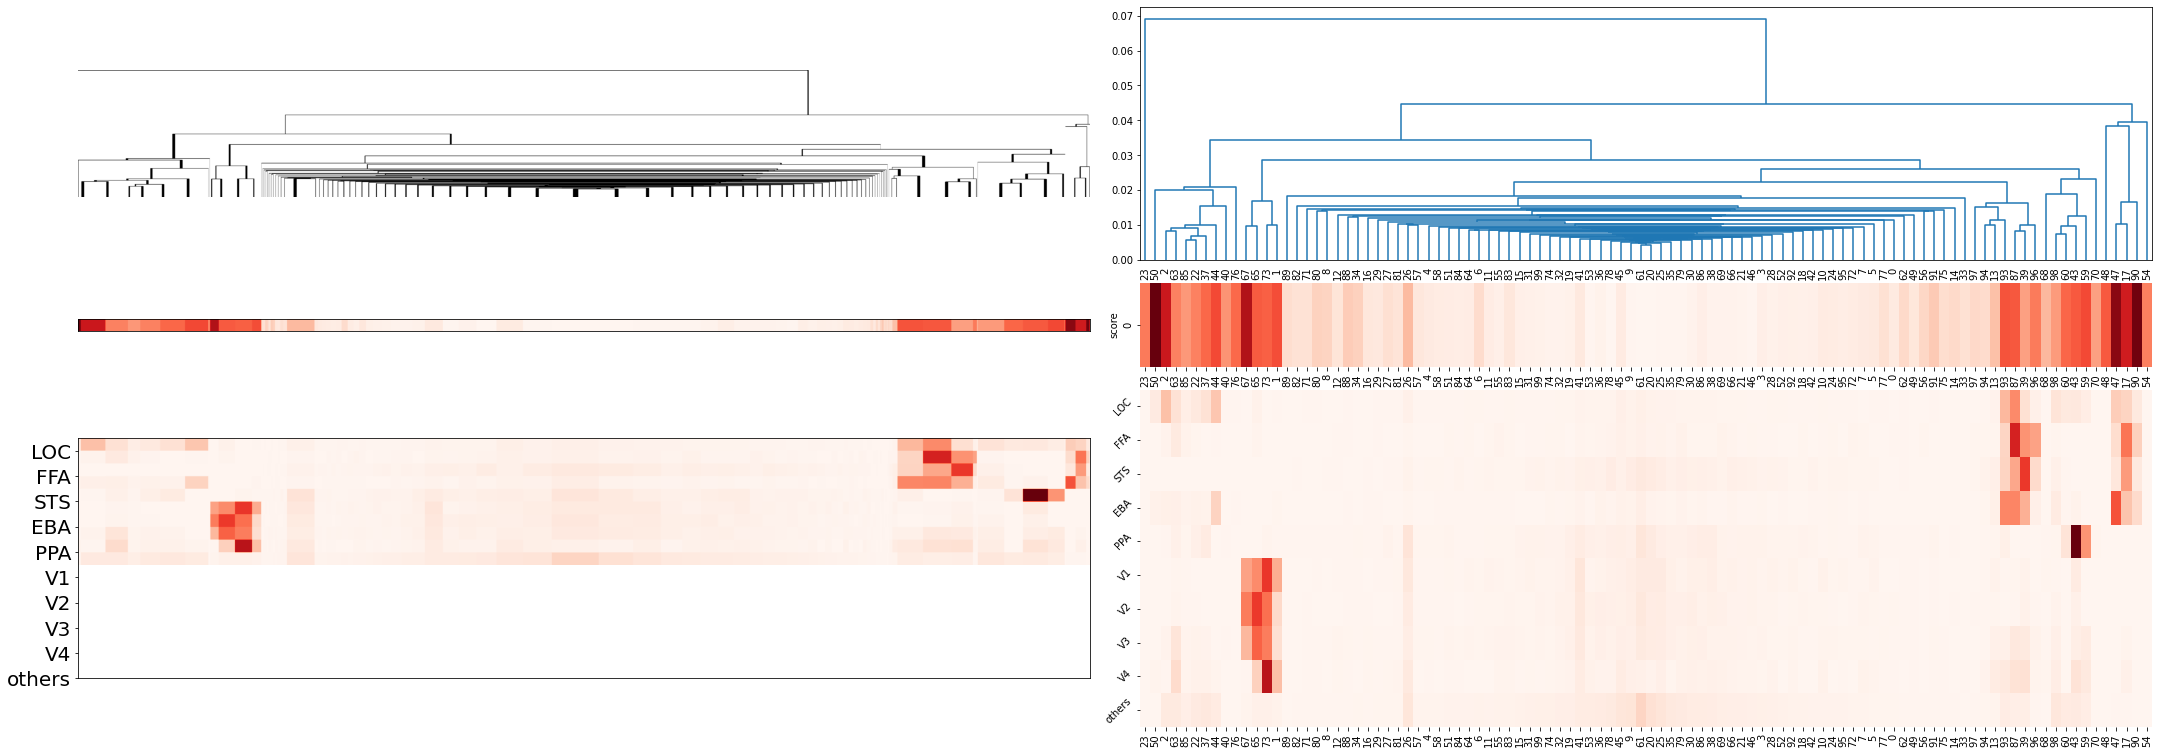

working on: 2d_seg_swin_warp_3d
nList is -  [76, 1, 33, 96, 70, 54]
cluster 1 [23, 50, 2, 63, 85, 22, 37, 44, 40, 76]
cluster 2 [67, 65, 73, 1]
cluster 3 [89, 82, 71, 80, 8, 12, 88, 34, 16, 29, 27, 81, 26, 57, 4, 58, 51, 84, 64, 6, 11, 55, 83, 15, 31, 99, 74, 32, 19, 41, 53, 36, 78, 45, 9, 61, 20, 25, 35, 79, 30, 86, 38, 69, 66, 21, 46, 3, 28, 52, 92, 18, 42, 10, 24, 95, 72, 7, 5, 77, 0, 62, 49, 56, 91, 75, 14, 33]
cluster 4 [97, 94, 13, 93, 87, 39, 96]
cluster 5 [68, 98, 60, 43, 59, 70]
cluster 6 [48, 47, 17, 90, 54]


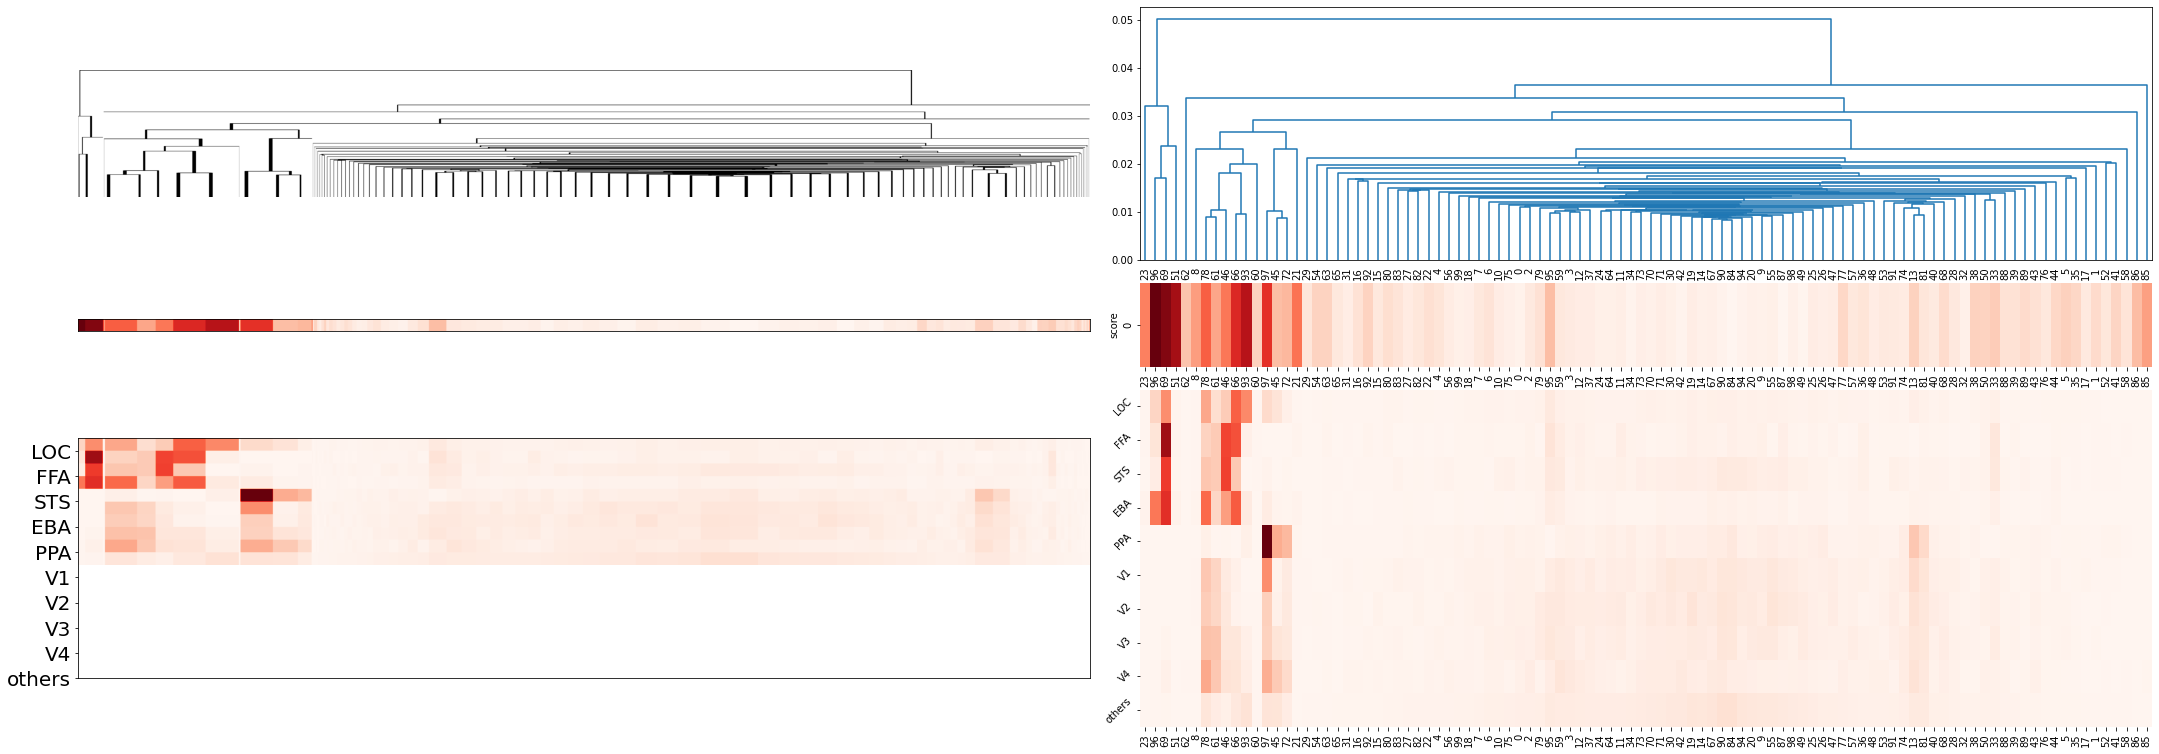

working on: audio_vggish
nList is -  [51, 46, 60, 21, 85]
cluster 1 [23, 96, 69, 51]
cluster 2 [62, 8, 78, 61, 46]
cluster 3 [66, 93, 60]
cluster 4 [97, 45, 72, 21]
cluster 5 [29, 54, 63, 65, 31, 16, 92, 15, 80, 83, 27, 82, 22, 4, 56, 99, 18, 7, 6, 10, 75, 0, 2, 79, 95, 59, 3, 12, 37, 24, 64, 11, 34, 73, 70, 71, 30, 42, 19, 14, 67, 90, 84, 94, 20, 9, 55, 87, 98, 49, 25, 26, 47, 77, 57, 36, 48, 53, 91, 74, 13, 81, 40, 68, 28, 32, 38, 50, 33, 88, 39, 89, 43, 76, 44, 5, 35, 17, 1, 52, 41, 58, 86, 85]


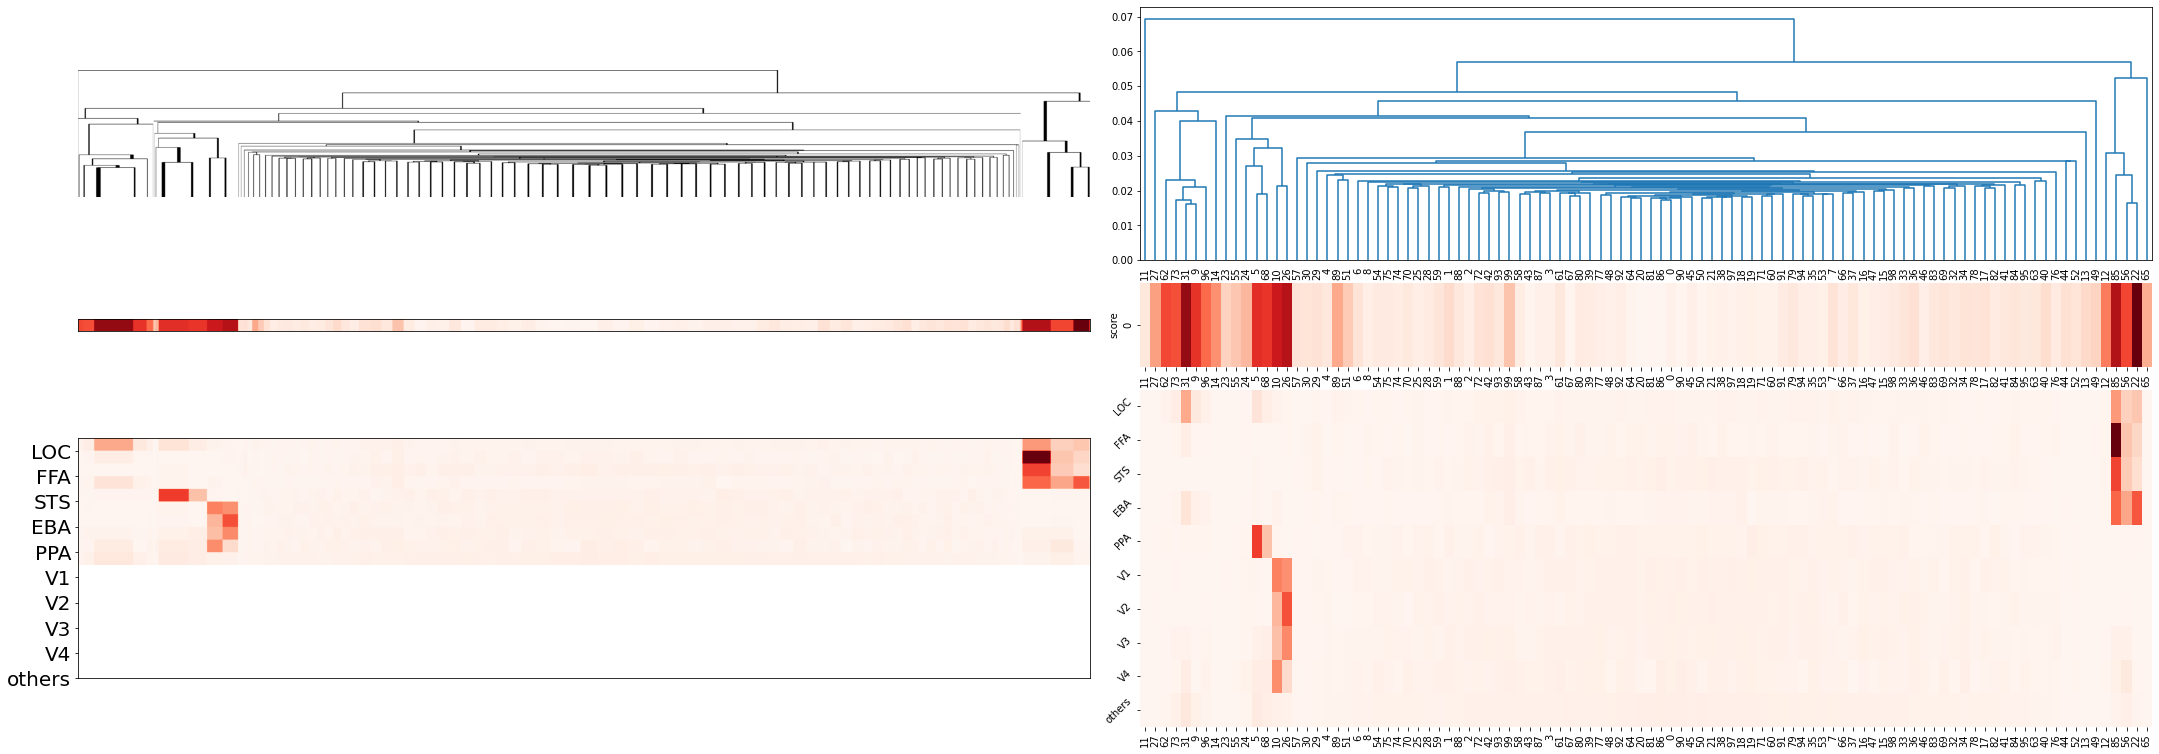

working on: 2d_pyconvsegnet_warp_3d
nList is -  [14, 68, 26, 49, 65]
cluster 1 [11, 27, 62, 73, 31, 9, 96, 14]
cluster 2 [23, 55, 24, 5, 68]
cluster 3 [10, 26]
cluster 4 [57, 30, 29, 4, 89, 51, 6, 8, 54, 75, 74, 70, 25, 28, 59, 1, 88, 2, 72, 42, 93, 99, 58, 43, 87, 3, 61, 67, 80, 39, 77, 48, 92, 64, 20, 81, 86, 0, 90, 45, 50, 21, 38, 97, 18, 19, 71, 60, 91, 79, 94, 35, 53, 7, 66, 37, 16, 47, 15, 98, 33, 36, 46, 83, 69, 32, 34, 78, 17, 82, 41, 84, 95, 63, 40, 76, 44, 52, 13, 49]
cluster 5 [12, 85, 56, 22, 65]


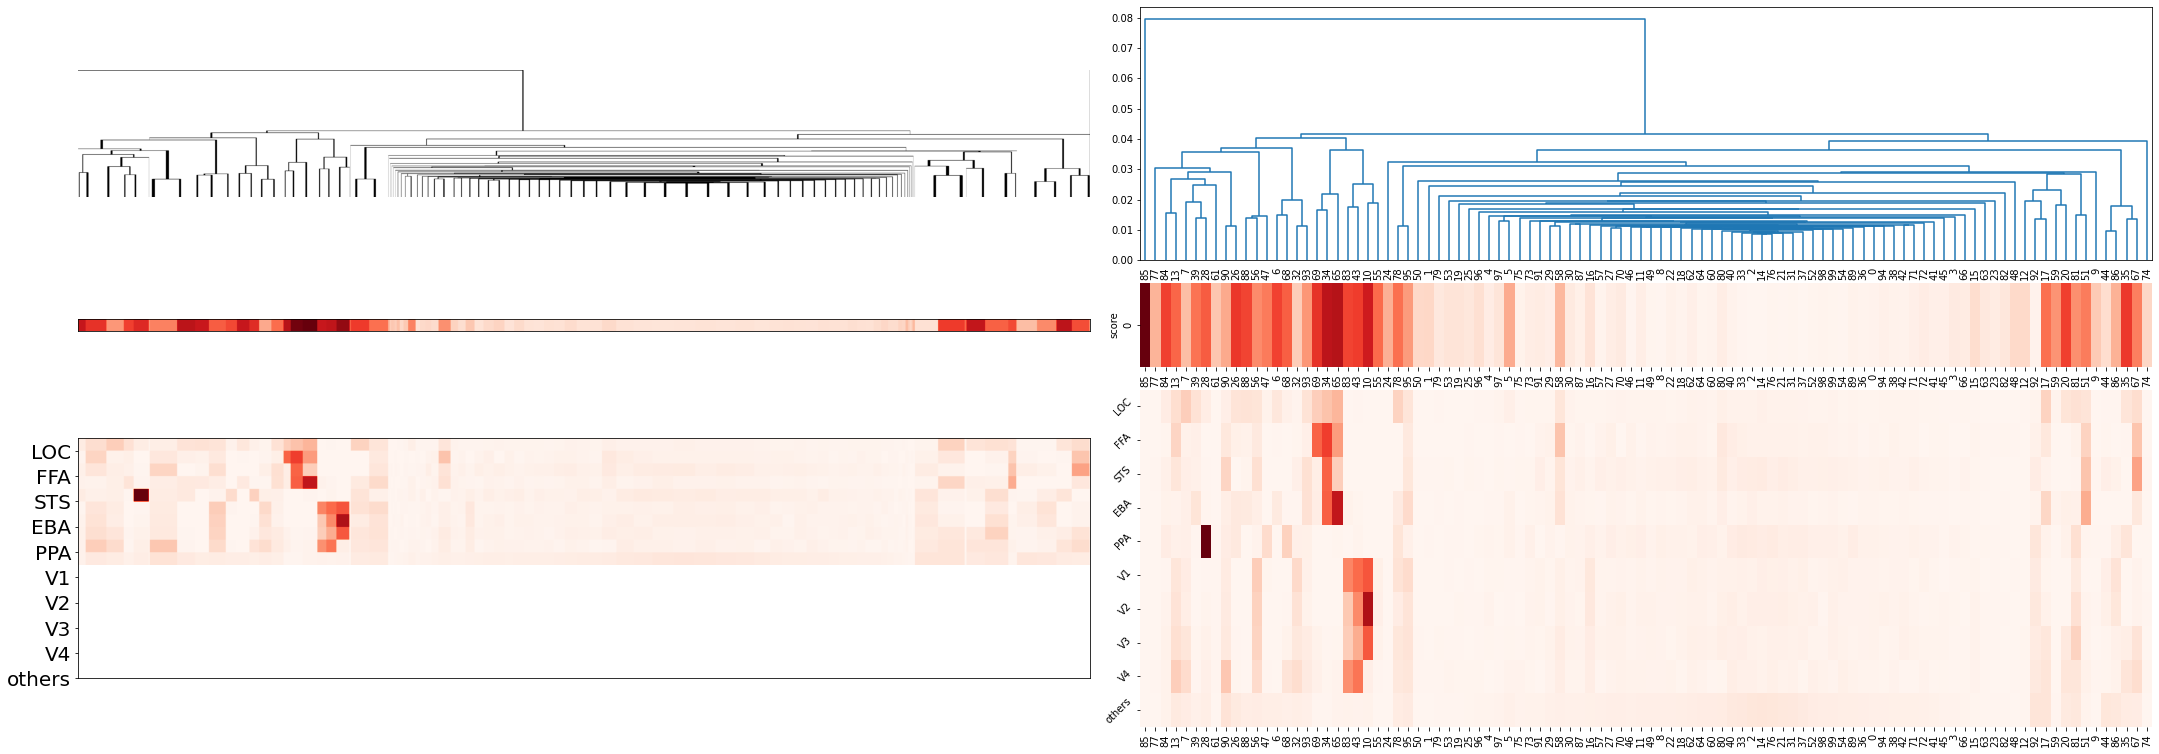

working on: 2d_simclr_warp_3d
nList is -  [26, 47, 93, 65, 55, 95, 48, 9, 74]
cluster 1 [85, 77, 84, 13, 7, 39, 28, 61, 90, 26]
cluster 2 [88, 56, 47]
cluster 3 [6, 68, 32, 93]
cluster 4 [69, 34, 65]
cluster 5 [83, 43, 10, 55]
cluster 6 [24, 78, 95]
cluster 7 [50, 1, 79, 53, 19, 25, 96, 4, 97, 5, 75, 73, 91, 29, 58, 30, 87, 16, 57, 27, 70, 46, 11, 49, 8, 22, 18, 62, 64, 60, 80, 40, 33, 2, 14, 76, 21, 31, 37, 52, 98, 99, 54, 89, 36, 0, 94, 38, 42, 71, 72, 41, 45, 3, 66, 15, 63, 23, 82, 48]
cluster 8 [12, 92, 17, 59, 20, 81, 51, 9]
cluster 9 [44, 86, 35, 67, 74]


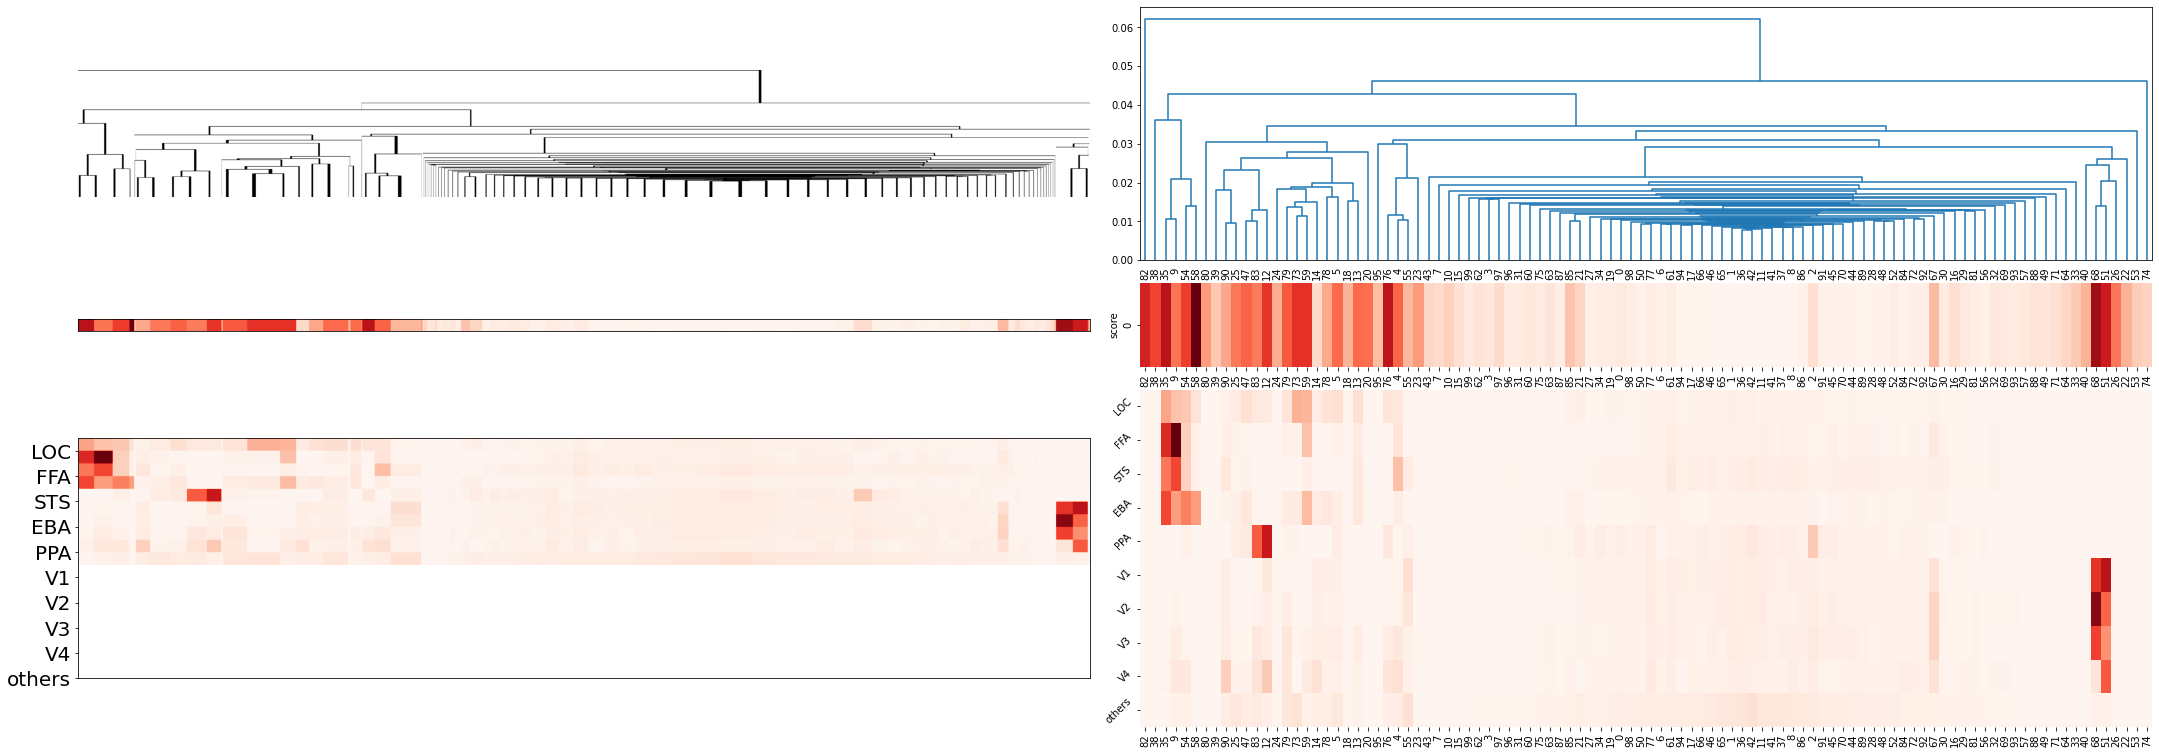

working on: 2d_colorizer_warp_3d
nList is -  [58, 12, 20, 23, 33, 74]
cluster 1 [82, 38, 35, 9, 54, 58]
cluster 2 [80, 39, 90, 25, 47, 83, 12]
cluster 3 [24, 79, 73, 59, 14, 78, 5, 18, 13, 20]
cluster 4 [95, 76, 4, 55, 23]
cluster 5 [43, 7, 10, 15, 99, 62, 3, 97, 96, 31, 60, 75, 63, 87, 85, 21, 27, 34, 19, 0, 98, 50, 77, 6, 61, 94, 17, 66, 46, 65, 1, 36, 42, 11, 41, 37, 8, 86, 2, 91, 45, 70, 44, 89, 28, 48, 52, 84, 72, 92, 67, 30, 16, 29, 81, 56, 32, 69, 93, 57, 88, 49, 71, 64, 33]
cluster 6 [40, 68, 51, 26, 22, 53, 74]


In [87]:
# work on every backbone
for backbone_name in backbone_names[:]:
    
    plt.clf()
    plt.cla()
    plt.close()
    
    km = torch.load(f'tmp/notebook011/{backbone_name}-kmeans.pt')
    voxel_scores = np.load(TEMP_DIR.joinpath(Path(f'{backbone_name}-voxel_scores.npy')))
    
    

    Z = linkage(km.cluster_centers_, 'ward', optimal_ordering=optimal_ordering)

    fig = plt.figure(figsize=(30, 10))
    dn = dendrogram(Z, get_leaves=True, color_threshold=0, link_color_func=lambda k: 'k')
    plt.axis('off')
    # plt.show()
    deno_img = get_img_from_fig(fig, dpi=350)
    plt.close()

    counts = [sum(km.labels_ == i) for i in dn['leaves']]
    counts = np.asarray(counts).reshape(1, -1)

    k = km.n_clusters

    new_img = my_rescale_denogram(counts, deno_img)

    im = Image.fromarray(new_img.astype(np.uint8))

    km_cluster_mean_scores = np.zeros(k)
    for i in range(k):
        km_cluster_mean_scores[i] = voxel_scores[km.labels_ == i].mean()

    dn_cluster_mean_scores = km_cluster_mean_scores[dn['leaves']]

    score_im = my_heatmap2(dn_cluster_mean_scores, counts)


    ### plot

    fig = plt.figure(constrained_layout=False, figsize=(30, 10))
    widths = [40, 40]
    heights = [3, 1, 4]
    spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                              height_ratios=heights, left=0.02, right=0.98, wspace=0.05)

    ## plot scaled
    
    # plot denogram
    plt.sca(fig.add_subplot(spec[0, 0]))
    plt.imshow(im)
    plt.axis('off')
    
    im.save(f'tmp/notebook012/sub figs/{backbone_name}-dendrogram.png')
    
    # plot score
    plt.sca(fig.add_subplot(spec[1, 0]))
    plt.imshow(score_im, cmap='Reds')
    plt.yticks([50], ['score'], rotation=0, ha='right', fontsize=20)
    plt.xticks([])
    
    np.save(f'tmp/notebook012/sub figs/{backbone_name}-score.npy', score_im)

    
    # plot anatomical rois for refrence
    plt.sca(fig.add_subplot(spec[2, 0]))
    new_labels = np.ones_like(km.labels_) * -1
    new_order = np.asarray(dn['leaves'])
    for i in range(km.n_clusters):
        new_labels[km.labels_ == new_order[i]] = i
    ls = new_labels

    def my_count(arr, m):
        counts = []
        for i in range(m):
            counts.append((arr==i).sum())
        counts = np.asarray(counts)
        return counts
    sidx = np.argsort(my_count(ls, k)).tolist()[::-1]

    counts = []
    for roi in rois:
        count = my_count(ls[anatomical_rois[roi]], k)
        counts.append(count)
    counts = np.stack(counts)
    percentages = counts / counts.sum(1, keepdims=True)
    
    img = my_heatmap(counts)

    plt.imshow(img, cmap='Reds')
    plt.yticks([50+i*100 for i in range(10)], label_rois, rotation=0, ha='right', fontsize=20)
    plt.xticks([])
    
    np.save(f'tmp/notebook012/sub figs/{backbone_name}-rois.npy', img)

    ## plot unscaled
    
    # plot denogram
    plt.sca(fig.add_subplot(spec[0, 1]))
    dn = dendrogram(Z, get_leaves=True, color_threshold=0, show_leaf_counts=True)
    plt.xticks(fontsize=10, rotation=90)
    
    # plot score
    plt.sca(fig.add_subplot(spec[1, 1]))
    sns.heatmap(dn_cluster_mean_scores.reshape(1, -1), xticklabels=dn['leaves'], cmap='Reds', cbar=False)
    plt.ylabel('score')
    
    
    # plot anatomical rois for refrence
    plt.sca(fig.add_subplot(spec[2, 1]))
    ax = sns.heatmap(percentages, yticklabels=label_rois, xticklabels=dn['leaves'], annot=False, cmap='Reds', cbar=False)
    plt.yticks(rotation=45)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0.1, wspace = 0.02)
    
    
    plt.show()    
    

    print("working on:", backbone_name)
    if not backbone_name in split_dict.keys():
        # number of elements
        # n = int(input("Enter number of clusters : "))
        # Below line read inputs from user using map() function
        # split_list = list(map(int,input("nEnter the numbers : ").strip().split()))[:n]
        split_list = list(map(int,input("nEnter the split breakpoints: ").strip().split()))
        split_dict[backbone_name] = split_list
    else:
        split_list = split_dict[backbone_name]
    print("nList is - ", split_list)
    
    
    # extract and save voxel_indices
    start = 0
    for i, end in enumerate(split_list):
        i += 1

        labels = dn['leaves'][start:dn['leaves'].index(end)+1]
        print(f'cluster {i}', labels)
        start += len(labels)

        voxel_idxs = []
        for l in labels:
            voxel_idx = (km.labels_ == l).nonzero()[0]
            voxel_idxs.append(voxel_idx)
        voxel_idxs = np.concatenate(voxel_idxs)
        voxel_idxs.sort()
        voxel_idxs = torch.tensor(voxel_idxs)
        torch.save(voxel_idxs, voxel_indices_save_dir.joinpath(Path(f'{backbone_name}_htROI{i}.pt')))
        
    title = ','.join([str(i) for i in split_list])
    
    fig.suptitle(title, fontsize=16)
    # plt.tight_layout()
    fig.savefig(f'tmp/notebook012/figs/{backbone_name}.pdf', bbox_inches='tight')
    
    plt.close()
    # clear_output(wait=True)

In [ ]:
split_dict

{'2d_densnet_warp_3d': [59, 21, 49, 60, 22, 82, 92],
 '3d_swin': [74, 75, 76, 99, 92, 93, 48],
 '2d_bdcnvgg_warp_3d': [92, 97, 78, 50, 31, 75, 61],
 'i3d_flow': [54, 22, 96, 99, 81, 83, 92],
 '2d_moby_swin_warp_3d': [59, 62, 66, 82, 86, 89],
 'i3d_rgb': [31, 69, 95, 81, 41, 85],
 '2d_seg_swin_warp_3d': [63, 73, 94, 26, 61, 98, 47],
 'audio_vggish': [96, 52, 93, 78, 72],
 '2d_pyconvsegnet_warp_3d': [31, 26, 68, 52, 56],
 '2d_simclr_warp_3d': [67, 95, 87, 92, 69, 55, 68, 88, 90, 39],
 '2d_colorizer_warp_3d': [73, 90, 97, 68, 55, 58]}

In [177]:
split_dict

{'2d_densnet_warp_3d': [59, 21, 49, 60, 22, 82, 92],
 '3d_swin': [74, 75, 76, 99, 92, 93, 48],
 '2d_bdcnvgg_warp_3d': [92, 97, 78, 50, 31, 75, 61],
 'i3d_flow': [54, 22, 96, 99, 81, 83, 92],
 '2d_moby_swin_warp_3d': [59, 62, 66, 82, 86, 89],
 'i3d_rgb': [31, 69, 95, 81, 41, 85],
 '2d_seg_swin_warp_3d': [63, 73, 94, 26, 61, 98, 47],
 'audio_vggish': [96, 52, 93, 78, 72],
 '2d_pyconvsegnet_warp_3d': [31, 26, 68, 52, 56],
 '2d_simclr_warp_3d': [67, 95, 87, 92, 69, 55, 68, 88, 90, 39],
 '2d_colorizer_warp_3d': [73, 90, 97, 68, 55, 58]}